In [1]:
import time

print(f"Last update: {time.ctime(time.time())}")

Last update: Tue Apr 13 10:42:37 2021


# Documentation of particles 'stuck' on boundaries
In many parcels simulations particles end up moving onto parts of the grid where the velocity field is not defined because it is part of a solid. Particles drifting on a model surface ocean move onto land cells for example. In this tutorial we look at how this happens in different velocity fields. **Short conclusion: interpolated or assimilated velocity fields may allow particles to get 'stuck'.**

The tutorial first looks at how velocity fields are structured and what that means for where the solid-fluid boundaries are located. Then we look at how particles may end up getting 'stuck' in these velocity fields.

* [Velocity fields](#Velocity-fields)
    * Numerical models
    * Data assimilation products
    * Interpolations of velocity fields
* [A grid interpolated velocity fields - SMOC](#A-grids)
* [C grid numerical model - NEMO](#C-grids)

## Velocity fields
Parcels can handle several different types of velocity fields, which makes it widely applicable. This also means that the underlying code and therefore the accuracy of the calculated trajectories can differ, depending on the velocity data input. Even when Parcels runs smoothly with the velocity fields you use, it is good to realise how your velocity fields are structured and how those velocities are generated in the first place. 

Velocity data may be structured on a staggered (Arakawa-B or Arakawa-C) or unstaggered grid (Arakawa-A). The implementation of these grids is covered in [this tutorial](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb). Then, the grids may be rectilinear (lat-lon) or curvilinear and in spherical or flat coordinates.  

The source of your velocity data will influence how accurate and consistent parcels can calculate trajectories. Common sources are numerical models, data assimilation products, and discretely sampled fields from either of the previous two or from observations. The most important difference between these sources is that the numerical models are mathematically consistent and mass-conserving, while the others not so necessarily. This can cause trajectories to run into the solid-fluid boundaries of the velocity field.

Here we will look at two examples of velocity fields in parcels. We visualize the structure of the velocity field, briefly discuss the Parcels implementation and look at how particles get stuck.

### A grids
Arakawa A grids are unstaggered grids where the velocities u, v (and w), pressure and other tracers are defined at the same position. These nodes can be located **at the center or the edges of the grid cells**. This means that the cell boundaries, and therefore the solid-fluid boundaries can either be located between the nodes or at the nodes respectively (see figure below).

Many ocean models are run on a C grid, because boundary conditions are more straightforward to implement there (see [C grid](#C-grids)). Often the C-grid output of these models is interpolated onto an A grid.

In [2]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable, Field, ScipyParticle, AdvectionDiffusionM1

import numpy as np
import xarray as xr
from datetime import timedelta as delta
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from scipy import interpolate
import os
import math
from IPython.display import Image

def _check_file_exist(File: str): return os.path.isfile(File)

INFO: Compiled ParcelsRandom ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\libparcels_random_c33e7bd1-1898-4d1b-b2e6-e0f4cb642ec3.so


In [3]:
# --------- Open dataset ---------
SMOCfile = 'SMOC_20190704_R20190705.nc'
SMOCfiles = ['SMOC_20190704_R20190705.nc','SMOC_20190705_R20190706.nc','SMOC_20190706_R20190707.nc','SMOC_20190707_R20190708.nc', 'SMOC_20190708_R20190709.nc']
flowdata_SMOC = xr.open_dataset(SMOCfile)


# --------- Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh ---------
dlon = flowdata_SMOC['longitude'][1]-flowdata_SMOC['longitude'][0]
dlat = flowdata_SMOC['latitude'][1]-flowdata_SMOC['latitude'][0]

# Outside corner coordinates
x_outcorners,y_outcorners = np.meshgrid(np.linspace(flowdata_SMOC['longitude'].values[0]-0.5*dlon, flowdata_SMOC['longitude'].values[-1]+0.5*dlon, len(flowdata_SMOC['longitude'])+1),
                np.linspace(flowdata_SMOC['latitude'].values[0]-0.5*dlat, flowdata_SMOC['latitude'].values[-1]+0.5*dlat, len(flowdata_SMOC['latitude'])+1))

# Inside corner coordinates
x_incorners,y_incorners = np.meshgrid(np.linspace(flowdata_SMOC['longitude'].values[0]+0.5*dlon, flowdata_SMOC['longitude'].values[-1]-0.5*dlon, len(flowdata_SMOC['longitude'])-1),
                np.linspace(flowdata_SMOC['latitude'].values[0]+0.5*dlat, flowdata_SMOC['latitude'].values[-1]-0.5*dlat, len(flowdata_SMOC['latitude'])-1))

# Center coordinates
x_centers, y_centers = np.meshgrid(np.linspace(flowdata_SMOC['longitude'].values[0], flowdata_SMOC['longitude'].values[-1], len(flowdata_SMOC['longitude'])),
                np.linspace(flowdata_SMOC['latitude'].values[0], flowdata_SMOC['latitude'].values[-1],len(flowdata_SMOC['latitude'])))


# --------- Velocity fields ---------
cells = np.zeros((len(flowdata_SMOC['latitude'])-1,len(flowdata_SMOC['longitude'])-1)) # Empty cells

umask = np.ma.masked_invalid(flowdata_SMOC['uo'][0,0])                                 # Masking the flowfield where U = NaN

u_zeros = np.nan_to_num(flowdata_SMOC['uo'][0,0])                                      # Velocity field with NaN -> zero to be able to use in interp2d
f = interpolate.interp2d(flowdata_SMOC['longitude'],flowdata_SMOC['latitude'],u_zeros) # Interpolator

u_corners = f(x_incorners[0,:],y_incorners[:,0])                                                   # Velocity field interpolated on the inside corners

udmask = np.ma.masked_values(u_corners,0)                                                          # Masking the interpolated flowfield where U = 0


# --------- Plotting domain ---------
lonminx = 2100
lonmaxx = 2500
latminx = 1300
latmaxx = 1750

SMOC_U = flowdata_SMOC['uo'][0,0,latminx:latmaxx,lonminx:lonmaxx].fillna(-100)                     # Selected velocity domain to plot

In [4]:
### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap('Blues')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0
my_cmap = ListedColormap(my_cmap)

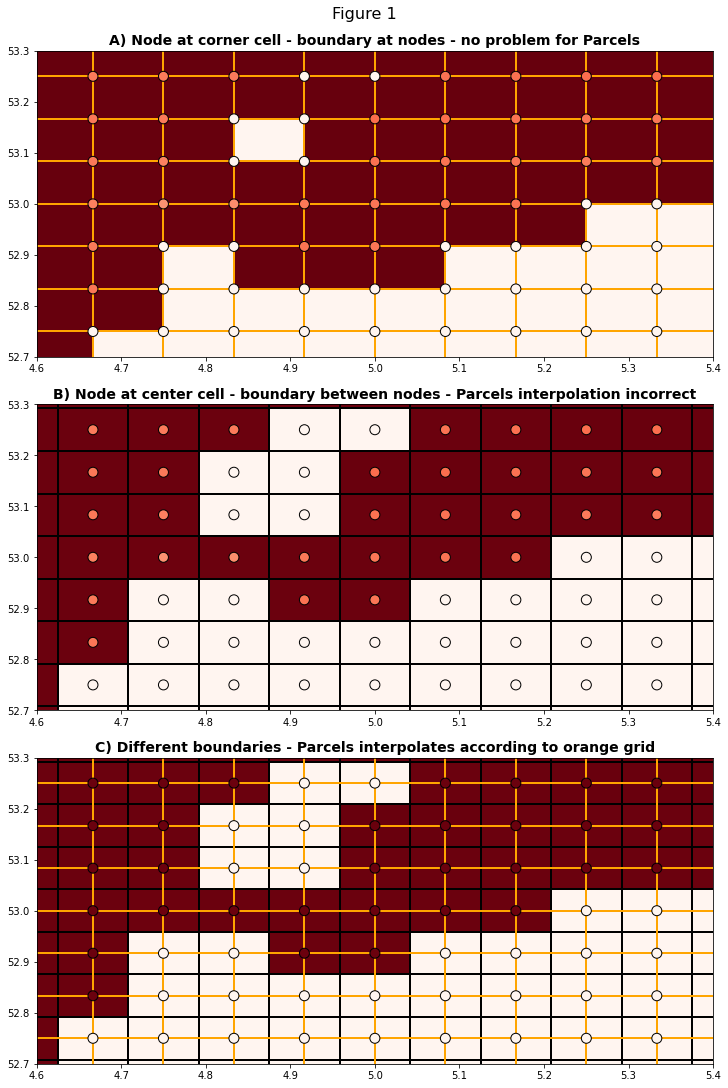

In [5]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15),constrained_layout=True)
fig.suptitle('Figure 1', fontsize=16)

ax1.set_xlim(4.6,5.4)
ax1.set_ylim(52.7,53.3)
ax1.set_title('A) Node at corner cell - boundary at nodes - no problem for Parcels', fontsize=14, fontweight = 'bold')
ax1.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange')
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='Reds',vmin=-2,vmax=2,edgecolors='k')

ax2.set_xlim(4.6,5.4)
ax2.set_ylim(52.7,53.3)
ax2.set_title('B) Node at center cell - boundary between nodes - Parcels interpolation incorrect', fontsize=14, fontweight = 'bold')
ax2.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],SMOC_U,cmap='Reds',edgecolors='k',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='Reds',vmin=-2,vmax=2,edgecolors='k')

ax3.set_xlim(4.6,5.4)
ax3.set_ylim(52.7,53.3)
ax3.set_title('C) Different boundaries - Parcels interpolates according to orange grid', fontsize=14, fontweight = 'bold')
ax3.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],SMOC_U,cmap='Reds',edgecolors='k',linewidth=1)
ax3.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],cells[latminx:latmaxx,lonminx:lonmaxx],cmap=my_cmap,edgecolors='orange')
ax3.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=100,c=SMOC_U,cmap='Reds',edgecolors='k')

#### Parcels bilinear interpolation
On Arakawa A grids, parcels uses a simple bilinear interpolation. This does not take into account any boundary condition and allows the velocity component normal to the boundary to persist in the limit towards the boundary.

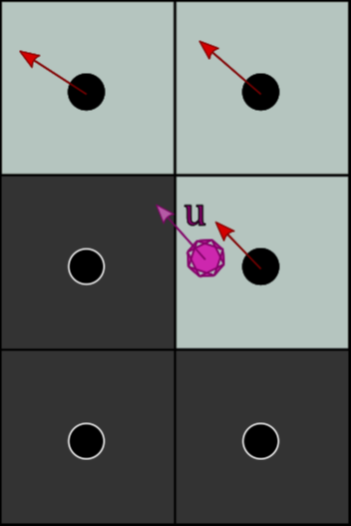

In [6]:
Image(filename='bilinear.png') 

Increasing the resolution will probably improve the tangential flow along boundaries, but the problem will remain at a smaller scale.

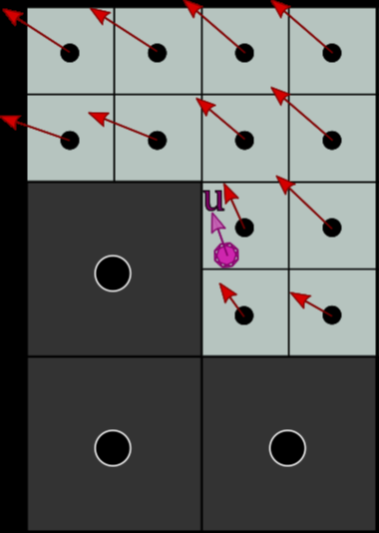

In [7]:
Image(filename='bilinear_hires.png') 

#### How do particles get stuck?

In [8]:
if _check_file_exist("SMOC.nc"):
    print('File exists - doing nothing')
else:
    print('Running simulation')
    SMOCfile = 'SMOC_201909*.nc'
    filenames = {'U': datadir+SMOCdir+SMOCfile,
                 'V': datadir+SMOCdir+SMOCfile}

    variables = {'U': 'uo',
                 'V': 'vo'}

    dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
                  'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

    npart = 3  # number of particles to be released
    lon = np.linspace(7, 7.2, npart, dtype=np.float32)
    lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
    lons, lats = np.meshgrid(lon,lat)
    time = np.zeros(lons.size)

    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

    kernels = pset.Kernel(AdvectionRK4)

    output_file = pset.ParticleFile(name="SMOC.nc", outputdt=delta(hours=1))

    pset.execute(kernels, runtime=delta(hours=119), dt=delta(minutes=12),
                 output_file=output_file)
    output_file.close()  # export the trajectory data to a netcdf file

File exists - doing nothing


In [9]:
ds_SMOC = xr.open_dataset('SMOC.nc')

In [10]:
# Tolerance based 
pdx = np.diff(ds_SMOC['lon'],axis=1,prepend=0)
pdy = np.diff(ds_SMOC['lat'],axis=1,prepend=0)
distance = np.sqrt(np.square(pdx)+np.square(pdy))
stuck = distance<0.00001

(-2e-05, 0.0002)

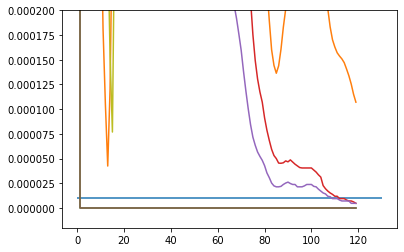

In [11]:
plt.plot(distance.T)
plt.hlines(0.00001,0,130)
plt.ylim(-0.00002,0.0002)

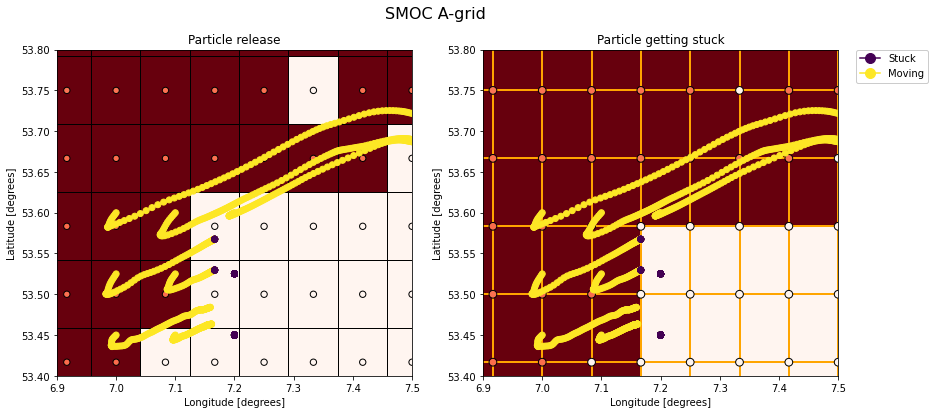

In [13]:
fig = plt.figure(figsize=(14,6))
fig.suptitle('SMOC A-grid', fontsize=16)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
       
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('Particle release')
ax1.set_xlim(6.9, 7.5)
ax1.set_ylim(53.4, 53.8)

ax1.pcolormesh(x_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_outcorners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=SMOC_U,cmap='Reds', vmin=-2, vmax=2, edgecolors='k')
ax1.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC['lon'], ds_SMOC['lat'], c= stuck, cmap='viridis_r', zorder=2)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(6.9, 7.5)
ax2.set_ylim(53.4, 53.8)

ax2.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=SMOC_U,cmap='Reds', vmin=-2, vmax=2, edgecolors='k')
ax2.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax2.scatter(ds_SMOC['lon'], ds_SMOC['lat'], c= stuck, cmap='viridis_r', zorder=2)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10)]
ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

### C grids

On staggered grids, different types of boundary conditions can be satisfied simultaneously. On a C-grid, the velocities are defined on the cell-edges normal to the velocity-component and pressure, temperature and tracers are defined at the cell centers. This way, the Dirichlet boundary condition can be used for the velocities, while the Neumann boundary condition can be satisfied for the gradient of pressure. Here we are going to look at how Parcels interprets the the boundaries in a C grid. First we show how the velocites are staggered and how the velocity input necessary to create a fieldset results in the definition of boundaries in parcels. In this case a NEMO dataset is used, but the C grid fieldset is similar when loading other velocity fields like from MITGCM.

In [14]:
cufields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05U.nc')
cvfields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05V.nc')

xu_corners, yu_corners = np.meshgrid(np.arange(cufields['x'].values[0], cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-0.5, cufields['y'].values[-1]+0.5, 1))
xv_corners, yv_corners = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+0.5, 1),
                np.arange(cvfields['y'].values[0], cvfields['y'].values[-1]+1, 1))
cx_centers, cy_centers = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+1.5, 1),
                np.arange(cvfields['y'].values[0]-0.5, cvfields['y'].values[-1]+1.5, 1))
fx_corners, fy_corners = np.meshgrid(np.arange(cufields['x'].values[0]-1, cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-1, cufields['y'].values[-1]+1, 1))
c_cells = np.zeros((len(cufields['y']),len(cufields['x'])))

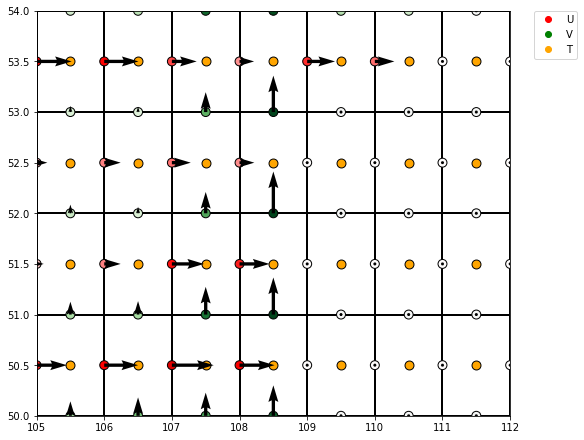

In [15]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)
ax1=plt.axes()

ax1.set_xlim(105, 112)
ax1.set_ylim(50, 54)
ax1.pcolormesh(fx_corners,fy_corners,c_cells,cmap=my_cmap,edgecolors='k',linewidth=1)
ax1.scatter(xu_corners,yu_corners, s=80,c=cufields['uos'][0],cmap='seismic',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'U')
ax1.scatter(xv_corners,yv_corners, s=80,c=cvfields['vos'][0],cmap='PRGn',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'V')
ax1.scatter(cx_centers,cy_centers, s=80,c='orange',edgecolor='k', label = 'T')
ax1.quiver(xu_corners,yu_corners,cufields['uos'][0],np.zeros(xu_corners.shape),angles='xy', scale_units='xy', scale=0.1, width=0.007)
ax1.quiver(xv_corners,yv_corners,np.zeros(xv_corners.shape),cvfields['vos'][0],angles='xy', scale_units='xy', scale=0.3, width=0.007)

custom_lines = [Line2D([0], [0], marker='o', color='r',lw=0),
                Line2D([0], [0], marker='o', color='g', lw=0),
                Line2D([0], [0], marker='o', color='orange', lw=0)]

ax1.legend(custom_lines, ['U', 'V', 'T'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Here you can see how a boundary can be traced along the cell edges where the velocity is zero. Because the velocities that are defined at the cell edges in a C-grid are the normal velocities, this ensures that the most important boundary condition in many models is satisfied: the normal-component of velocity is zero at the boundary.

#### Consistency with NEMO configuration
Here we look at how the lateral boundary conditions are implemented in NEMO. This is documented [here](https://www.nemo-ocean.eu/doc/node58.html)). 

The normal-component of velocity, defined at the cell faces where the boundary is defined, is set to zero at all boundaries. See the figure below. This corresponds exactly with the velocity field in a Parcels fieldset detailed above.

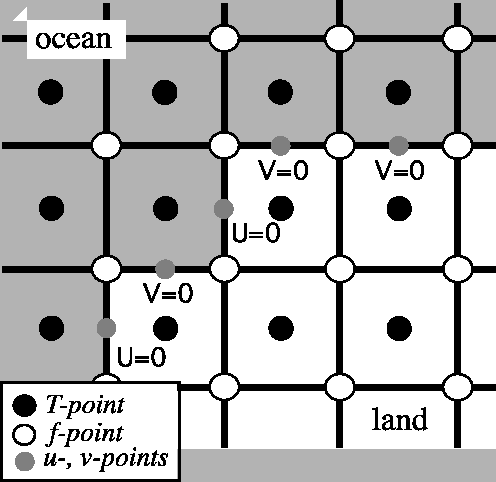

In [16]:
from IPython.display import Image
Image(filename='NEMO_latBC.png') 

There are different options for the tangential velocity in NEMO: a free-slip condition, a partial-slip condition and a no-slip condition. Since the tangential velocity is not defined at the boundary, this boundary condition is defined by a Neumann boundary condition: the normal derivative of the tangential velocity is specified. This derivative is schematically represented by a "ghost" velocity in the solid domain. The specified derivative is equivalent to what would result from the central difference between the tangential velocity at the nearest ocean cell and this "ghost" velocity. The type of boundary condition defines the direction and magnitude of this "ghost" velocity relative to the tangential velocity in the fluid domain. In Parcels, these "ghost" velocities may be used to determine how the velocit should be interpolated near the coast. **Question: Parcels interpolates piecewise-constant in the y-direction for the U velocity and in the x-direction for the V velocity right? If so, this probably results in a free-slip condition as shown in a) in the figure below** 

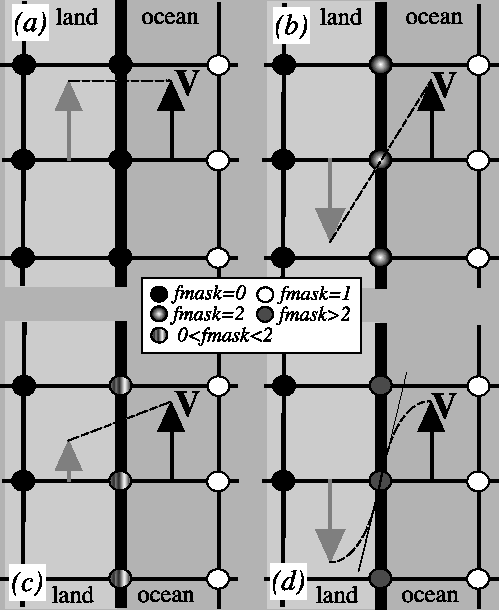

In [17]:
Image(filename='NEMO_ghost_vel.png')

If the interpolation in Parcels is piecewise-constant in the direction normal to the boundary, the tangential velocity at the boundary is the same as the tangential velocity in the last fluid cell: a free-slip boundary. If the interpolation is linear between the nodes at either side of the boundary, there would be a smaller tangential velocity at the boundary: a partial-slip boundary.

In [18]:
from glob import glob

data_path = 'NemoNorthSeaORCA025-N006_data/'
ufiles = sorted(glob(data_path+'ORCA*U.nc'))
vfiles = sorted(glob(data_path+'ORCA*V.nc'))
wfiles = sorted(glob(data_path+'ORCA*W.nc'))
mesh_mask = data_path + 'coordinates.nc'

coords = xr.open_dataset(mesh_mask, decode_times=False)

In [19]:
if _check_file_exist("Cgrid.nc"):
    print('File exists - doing nothing')
else:
    print('Running simulation')
    filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

    variables = {'U': 'uo',
                 'V': 'vo',
                 'W': 'wo'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

    fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

    npart = 10  # number of particles to be released
    lon = np.linspace(3 , 4, npart, dtype=np.float32)
    lat = 51.5 * np.ones(npart)
    time = np.zeros(npart)

    pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

    output_file = pset.ParticleFile(name="Cgrid.nc", outputdt=delta(hours=1))
    pset.execute(AdvectionRK4, runtime=delta(days=10), dt=delta(minutes=5),
                 output_file=output_file)
    output_file.close()  # export the trajectory data to a netcdf file

         It will be opened with no decoding. Filling values might be wrongly parsed.


Running simulation


INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\lib78a639f5c52b7249f3508c0282c89558_0.dll


In [20]:
data = xr.open_dataset('Cgrid-stuck.nc')

In [21]:
pdx = np.diff(data['lon'],axis=1,prepend=0)
pdy = np.diff(data['lat'],axis=1,prepend=0)
distance = np.sqrt(np.square(pdx)+np.square(pdy))
stuck = distance<(10/1000000)

(0.0, 0.01)

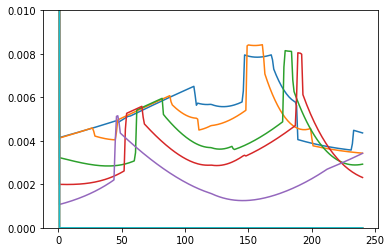

In [22]:
plt.plot(distance.T)
plt.ylim(0,0.01)

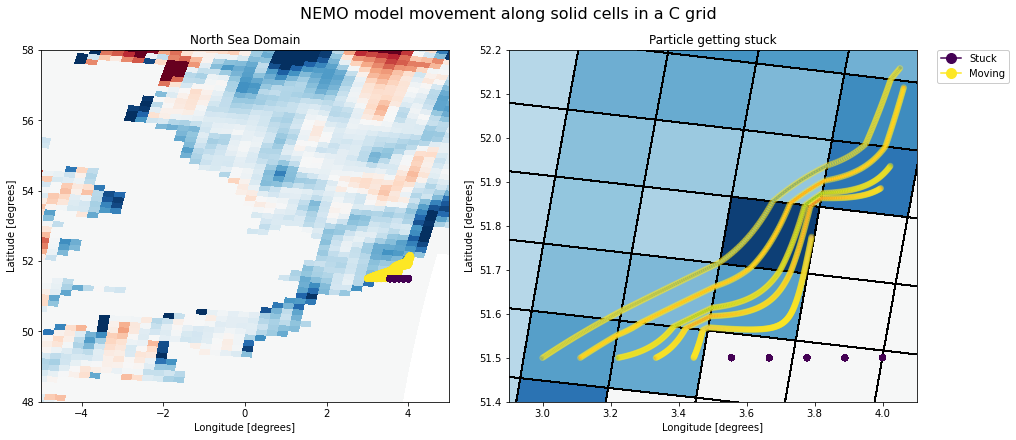

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6),constrained_layout=True)
fig.suptitle('NEMO model movement along solid cells in a C grid', fontsize=16)

ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('North Sea Domain')
ax1.set_xlim(-5, 5)
ax1.set_ylim(48, 58)

ax1.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1)
ax1.plot(data['lon'].T, data['lat'].T,linewidth=3,zorder=1)
ax1.scatter(data['lon'], data['lat'], c= stuck, cmap='viridis_r', zorder=2)

ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(2.9, 4.1)
ax2.set_ylim(51.4, 52.2)

ax2.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1,edgecolors='k',linewidth=1)
ax2.plot(data['lon'].T, data['lat'].T,linewidth=3,zorder=1)
ax2.scatter(data['lon'], data['lat'], c= stuck, s=30, cmap='viridis_r', alpha=0.3, zorder=2)

color_stuck = copy(plt.get_cmap('viridis'))(0)
color_moving = copy(plt.get_cmap('viridis'))(256)
custom_lines = [Line2D([0], [0], c = color_stuck, marker='o', markersize=10),
                Line2D([0], [0], c = color_moving, marker='o', markersize=10)]
ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
plt.show()

The free-slip or partial-slip boundary results in a tangential flow along the boundary.